# 千葉県 自転車盗難データ分析レポート

このレポートでは、千葉県警のオープンデータを利用し、  
過去1年間に発生した自転車盗難の傾向を分析した。

- どの地域で盗難が多いか
- 月ごとの発生件数  
- 鍵の有無で発生率はどう変わるか 
- どの時間帯に多いか     
- 被害者の特徴（職業など）

などをPythonでまとめた。


In [3]:
import pandas as pd

df = pd.read_csv("jitensha.csv")
df.head()

,罪名,手口,管轄警察署（発生地）,管轄交番・駐在所（発生地）,市区町村コード（発生地）,都道府県（発生地）,市区町村（発生地）,町丁目（発生地）,発生年月日（始期）,発生時（始期）,発生場所,発生場所の詳細,被害者の年齢,被害者の職業,施錠関係
0,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240117,23,その他の住宅（３階建て以下共同住宅等）,駐車（輪）場,20歳代,大学生,施錠した
1,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240227,18,駐車（輪）場,駐車（輪）場,10歳代,中学生,施錠せず
2,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240528,20,駐車（輪）場,駐車（輪）場,40歳代,その他,施錠した
3,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240627,21,駐車（輪）場,駐車（輪）場,10歳代,中学生,施錠せず
4,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240917,14,その他,その他,20歳代,その他,施錠せず


## 基本情報

データの行数・列数、欠損の有無などを確認する。


In [4]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9943 entries, 0 to 9942
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   罪名             9943 non-null   object 
 1   手口             9943 non-null   object 
 2   管轄警察署（発生地）     9943 non-null   object 
 3   管轄交番・駐在所（発生地）  9938 non-null   object 
 4   市区町村コード（発生地）   9942 non-null   float64
 5   都道府県（発生地）      9942 non-null   object 
 6   市区町村（発生地）      9942 non-null   object 
 7   町丁目（発生地）       9921 non-null   object 
 8   発生年月日（始期）      9943 non-null   object 
 9   発生時（始期）        9943 non-null   object 
 10  発生場所           9943 non-null   object 
 11  発生場所の詳細        9943 non-null   object 
 12  被害者の年齢         9943 non-null   object 
 13  被害者の職業         9943 non-null   object 
 14  施錠関係           9943 non-null   object 
dtypes: float64(1), object(14)
memory usage: 1.1+ MB


罪名                0
手口                0
管轄警察署（発生地）        0
管轄交番・駐在所（発生地）     5
市区町村コード（発生地）      1
都道府県（発生地）         1
市区町村（発生地）         1
町丁目（発生地）         22
発生年月日（始期）         0
発生時（始期）           0
発生場所              0
発生場所の詳細           0
被害者の年齢            0
被害者の職業            0
施錠関係              0
dtype: int64

## 市区町村ごとの盗難件数（多い順）


In [37]:
# 市区町村別件数のトップ10
city_counts = df.groupby('市区町村（発生地）').size().sort_values(ascending=False).head(10)

# Series → DataFrame化
city_counts = city_counts.reset_index(name='件数')
city_counts = city_counts.rename(columns={'市区町村（発生地）': '市区町村'})

# インデックスを消して表示
city_counts.style\
    .set_caption("市区町村別 自転車盗難件数（上位10件）")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th.row_heading', 'props': 'display: none;'},
        {'selector': 'th.blank', 'props': 'display: none;'}
    ])


,市区町村,件数
0,船橋市,1263
1,市川市,872
2,柏市,691
3,松戸市,678
4,千葉市中央区,656
5,八千代市,458
6,習志野市,450
7,浦安市,435
8,野田市,367
9,千葉市稲毛区,334


市区町村別の盗難件数を見ると、商業地・交通拠点のある都市部で件数が集中していることが分かる。  
船橋・市川・柏・松戸・千葉市中央区などは駅周辺に駐輪場が多く、人が多く、短時間の放置も多いため、盗難が発生しやすいと考えられる。   
一方で八千代・習志野・浦安・稲毛区・野田市などは住宅街や大学が多く、通勤通学の自転車利用者の割合が高いことが影響している。

全体として、人口が多い・人が集まる・自転車の集積がある地域ほど、盗難リスクが高い傾向にある。

## 月別の盗難件数


In [21]:
monthly_counts = df.groupby('月').size().reset_index(name='件数')

# 月を整数に変換
monthly_counts['月'] = monthly_counts['月'].astype(int)

# インデックスを消して表示
monthly_counts.style\
    .set_caption("月別自転車盗難件数")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th.row_heading', 'props': 'display: none;'},
        {'selector': 'th.blank', 'props': 'display: none;'}
    ])


,月,件数
0,1,620
1,2,569
2,3,681
3,4,761
4,5,813
5,6,826
6,7,1027
7,8,943
8,9,984
9,10,956


月別の盗難件数を見ると、4月頃から増加し、7月にピークを迎えている。  
これは気温の上昇により自転車利用者が増え、外出時間が長くなるためだと考えられる。   
その後も夏から秋にかけて高い水準が続き、10〜11月にも多く発生している。  
一方で冬季（12〜2月）は件数が少なく、季節による利用頻度の違いが盗難件数に大きく影響していることが分かる。  

## 鍵の有無による盗難件数の比較（Impact）


In [20]:
lock_counts = df.groupby('施錠関係').size().sort_values(ascending=False)

# Series → DataFrame
lock_counts = lock_counts.reset_index(name='件数')
lock_counts = lock_counts.rename(columns={'施錠関係': '施錠状況'})

# インデックス非表示で表を表示
lock_counts.style\
    .set_caption("施錠状況別 自転車盗難件数")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th.row_heading', 'props': 'display: none;'},
        {'selector': 'th.blank', 'props': 'display: none;'}
    ])


,施錠状況,件数
0,施錠せず,6781
1,施錠した,3162


データを見ると、盗難件数の約 68％ が「無施錠」の状態で発生している。  
施錠している場合と比べると **およそ 2.1倍** の件数であり、  
自転車盗難の大きな要因が「鍵をかけていないこと」であることが分かる。

## 発生時間帯の傾向


In [19]:
time_counts.style\
    .set_caption("発生時別 自転車盗難件数（0〜23時 順）")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th.row_heading', 'props': 'display: none;'},
        {'selector': 'th.blank', 'props': 'display: none;'}
    ])


,発生時,件数
0,0,167
1,1,74
2,2,32
3,3,23
4,4,30
5,5,113
6,6,333
7,7,919
8,8,675
9,9,411


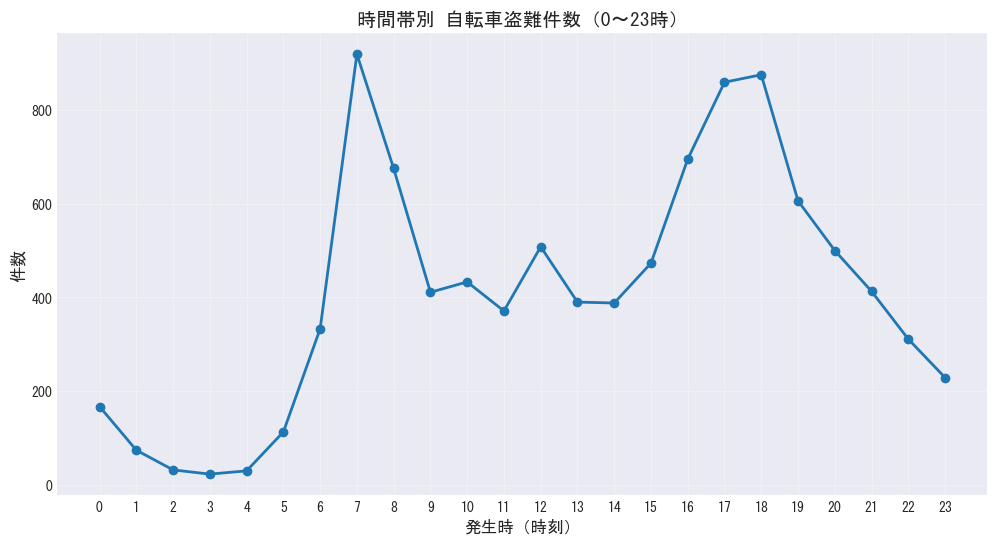

In [42]:
# 時間帯別件数を計算
hour_counts = df.groupby('発生時（始期）').size().reset_index(name='件数')
hour_counts['発生時（始期）'] = hour_counts['発生時（始期）'].astype(int)

# 時間順に並べ替え
hour_counts = hour_counts.sort_values('発生時（始期）')

# グラフ描画
plt.figure(figsize=(12, 6))
plt.plot(hour_counts['発生時（始期）'], hour_counts['件数'], marker='o', linewidth=2)

# 日本語フォント
plt.rcParams['font.family'] = 'MS Gothic'

plt.title("時間帯別 自転車盗難件数（0〜23時）", fontsize=14, fontweight='bold')
plt.xlabel("発生時（時刻）", fontsize=12)
plt.ylabel("件数", fontsize=12)
plt.grid(alpha=0.3)

# x目盛りを0〜23に
plt.xticks(range(0, 24))

plt.show()


- **最も多い時間帯は 7〜10時 と 16〜20時**  
  通勤・通学、帰宅時間帯と重なり、長時間放置されることが多い場所が狙われやすい。

- **深夜帯（1〜4時）は件数が極端に少ない**  
  人通りがなく、放置自転車自体が少ないことが理由と考えられる。
  
- **18時前後が1日の中で最も多く、875件発生**  
  駐輪場が暗くなることで、犯行がしやすくなる可能性が高い。

以上から、自転車盗難は「深夜より昼間や夕方のほうが圧倒的に多い」  
という意外な傾向が明確に示された。


## 被害者の職業別の件数（上位10）


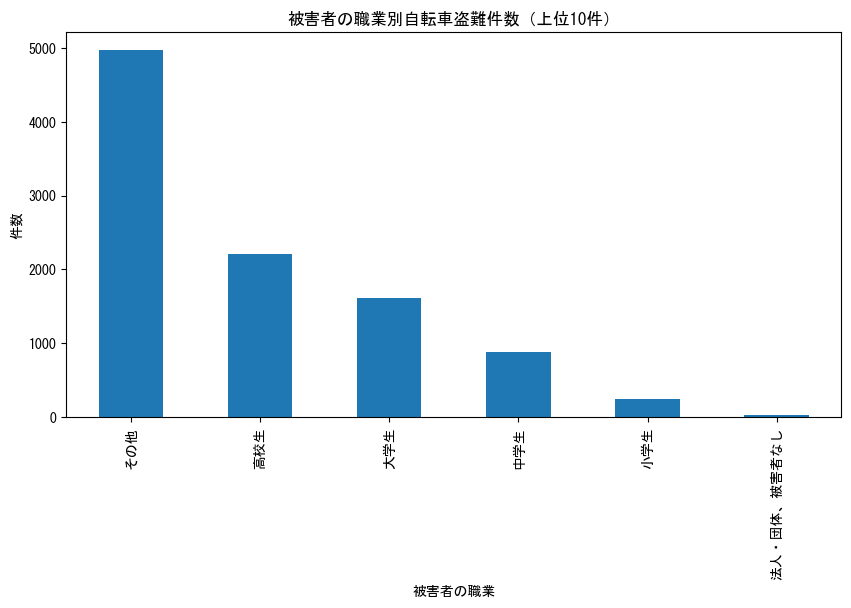

In [32]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'MS Gothic'

occupation_counts = df['被害者の職業'].value_counts().head(10)
occupation_counts.plot(kind='bar', figsize=(10,5))
plt.xlabel('被害者の職業')
plt.ylabel('件数')
plt.title('被害者の職業別自転車盗難件数（上位10件）')
plt.show()


## 被害者の年齢

In [33]:
age_df.style.set_caption("年齢別 自転車盗難件数").set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}
])


,年齢,件数
0,10歳代,4342
1,10歳未満,64
2,20歳代,2693
3,30歳代,986
4,40歳代,751
5,50歳代,537
6,60-64歳,166
7,65-69歳,88
8,70歳以上,286
9,法人・団体、被害者なし,30


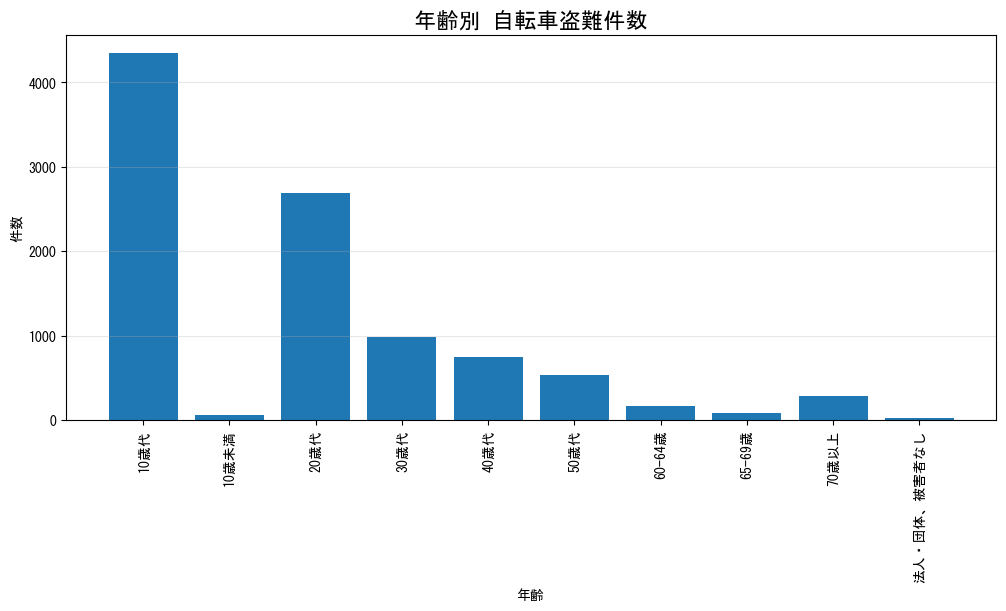

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.bar(age_df['年齢'], age_df['件数'])
plt.xlabel('年齢')
plt.ylabel('件数')
plt.title('年齢別 自転車盗難件数', fontsize=16)
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.show()


年齢別に見ると、自転車盗難の被害者は 10〜20代の若年層が目立ち、特に学生・通勤層の比率が高いことが分かる。　また高齢者の件数は比較的少なく、日常的に自転車を使う層が主なターゲットになっていると推測される。

## まとめ

本分析では、千葉県内の自転車盗難データを用いて、発生傾向を多角的に整理した。  
地域別では船橋市・市川市・柏市が突出して多く、都市部周辺に集中する傾向が確認された。  
月別では 7月をピーク に夏季の発生件数が増加し、時間帯では 朝7時前後と夕方17〜19時 に明確なピークが見られた。  

また、施錠の有無では 施錠なしの盗難が施錠ありの約2倍以上 発生しており、鍵の有無が盗難リスクに与える影響が極めて大きいことが分かった。  

これらの結果から、自転車盗難は  
**「都市部」「夏季」「通勤通学時間帯」「無施錠」**  
という条件が重なることで、特に発生しやすくなると考えられる。  